# EVAC Examination

## Data Exploration

In [710]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [711]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 128
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) +(numHiddenNodes1 * numOutputNodes)



/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_79663/3462940624.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [712]:
all_data = pd.read_csv('eScooterDemand.csv')
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


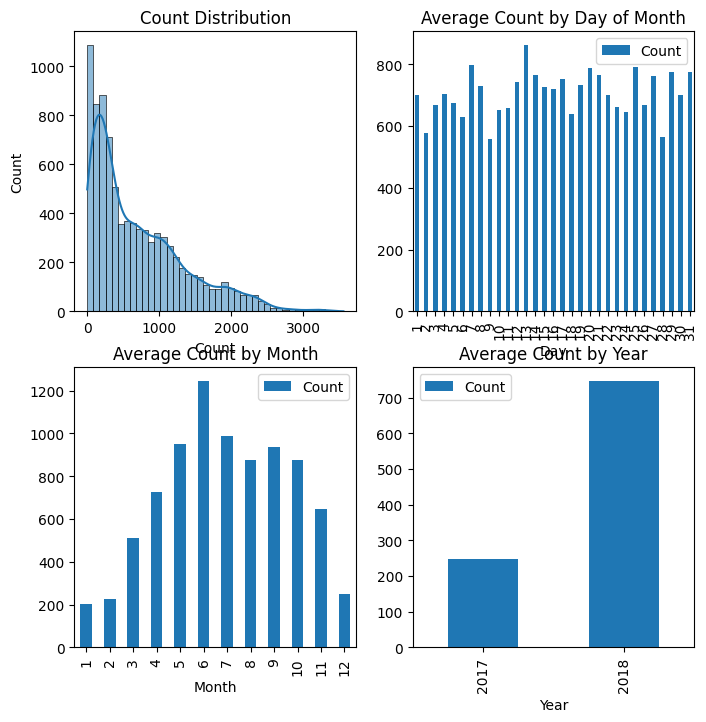

In [713]:


## plot average count over time to look for patterns that can be used to predict future demand
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(all_data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


In [714]:
all_data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [715]:
!pip install deap

854386.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [716]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator
from IPython import display


In [717]:
## Prepare data for training
all_data['Windspeed'] = all_data['Wind speed']
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [718]:
all_data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [719]:

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans
    
    def feedForward(self, inputs):
      inputsBias = inputs[:]
      inputsBias.insert(len(inputs),1)                 # Add bias input
      h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
      h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
      output = np.dot(self.wo, h1)                 # feed to output layer
      # output = [self.sigmoid(x) for x in output]   # Activate output layer
      return output
    
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

myNet = MLP(numInputNodes, numHiddenNodes1, numOutputNodes)



In [720]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [721]:
import numpy
# randomise data
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = all_data.sample(frac=0.2)
train_data = all_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(test_data.size)

print(train_data.size)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


35040
140160


In [722]:
def eval(individual, myNet, evdata):
  myNet.setWeightsLinear(individual)
  fitness = 0
  for i in range(len(evdata)):
    input = [evdata['PublicHoliday'][i], evdata['Weekend'][i], evdata['Month'][i], evdata['Hour'][i], evdata['Temp'][i], evdata['Windspeed'][i], evdata['Visibility'][i]]
    output = myNet.feedForward(input)
    fitness += abs(evdata['Count'][i] - output[0])
  return fitness/len(evdata),


In [723]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.6)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

baseline = toolbox.evaluate(myNet.getWeightsLinear(), myNet, train_data)
print(baseline)

(4325.466648126643,)


In [724]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [725]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
ind.fitness.values = toolbox.evaluate(ind, myNet, train_data)
print(ind.fitness.valid)
print(myNet.setWeightsLinear(ind))
print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet, train_data))

[-0.08259697659575482, -0.45189546184933116, 0.8126781492050517, 0.3885025266934723, 0.556643782052975, -0.8476406084987196, -0.3397304589203125, -0.5774522511375706, 0.6515539784510074, -0.7071661841417352, -0.9522328967897102, 0.4526919897375432, 0.05557516505548876, -0.6797660147510141, 0.0696035950754128, -0.9752572631001475, -0.04579074219386725, -0.17835907200253542, -0.4947702348769838, 0.11807409205683461, -0.8933396596767731, -0.23019813094066133, -0.5633283355641832, -0.20584273993933988, -0.006801396468999021, 0.19636698829835986, 0.8914763557445144, -0.08283356267288866, -0.12203621737611803, 0.8726786541007325, 0.9949813070547981, -0.7157003531091579, -0.46111575723053555, -0.15463599749965762, 0.8743815728373523, 0.3226370482099099, 0.5018521310209985, -0.603251652813894, 0.2745329743077385, -0.42329787240410055, 0.15703863493872627, 0.16930538677325346, -0.5963463658098664, -0.3245210907552447, -0.5039951897352755, 0.9737577425985195, -0.189573094633541, 0.61506446925038

In [726]:
logbook = tools.Logbook()
hof = tools.HallOfFame(1)
pop = toolbox.population(n=100)

In [727]:
fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [728]:
NGEN = 50

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

    gen = [g] * 100
    hof.update(pop)



-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --


In [729]:
print(logbook)


avg    	gen	max    	min    	std    
3439.78	0  	12901.8	462.954	2617.09
3778.84	1  	15591  	447.951	2923.63
4252.93	2  	12995.7	504.167	2810.58
5309.35	3  	19137.7	488.176	3980.52
4949.27	4  	14843.1	404.352	3214.53
4941.96	5  	14742  	363.743	3574.11
5926.71	6  	20240.1	473.192	4414.25
6060.55	7  	20440.6	523.198	4580.77
6142.27	8  	25013.3	394.074	4735.29
5788.88	9  	19053.9	498.706	4187.67
6901.82	10 	21957.4	422.418	4725.79
7666.94	11 	28525.3	405.82 	5963.87
7797.24	12 	26206.3	524.046	5767.5 
8579.99	13 	24251  	707.47 	5702.97
8599.05	14 	36268.3	528.52 	6439.06
9884.52	15 	26642.8	548.743	6298.25
9170.93	16 	41833.2	437.192	7318.58
8278.45	17 	39055.1	434.104	7076.03
8756.34	18 	27771.8	384.243	6615.22
9963.24	19 	34750.1	470.986	7416.65
9100.93	20 	43455.3	412.756	8011.3 
9030.89	21 	36281.3	495.245	7338.6 
10006.3	22 	29251.7	427.742	7033.54
11282.6	23 	38168.5	879.9  	8381.93
9559.69	24 	33956.1	411.765	7813   
10860  	25 	33414.4	397.114	7929.8 
9374.1 	26 	30050.2	534.986	

[0.8343743570975427, 0.426283289756885, 0.8057766138367931, 0.9186274332297126, -1.5363570082023446, 2.666384495744765, -2.8154132831251286, 1.9150304016060131, -3.2630842246439884, 2.2755593047172953, 0.10421594139005194, -1.1489951528018967, 0.2934724742506736, -1.8020382220151794, 2.2687733235277494, -1.9293336307881015, 2.3432509095633165, 1.7371282202395695, -1.133909291353342, -2.6333399032938924, 2.0110111754483855, -1.3505427619164079, -4.281194991314509, 2.9423097947808006, 4.086878783069195, -4.517570422812807, -5.764847942461865, 4.483702100012477, 0.4638075258707242, 5.20151313471313, 0.8462988864441712, -3.62438772888127, 2.6242127915784135, 1.894889971649088, 0.04533207994890043, 1.2474671484097823, -2.786199133741324, -2.9926582347487183, -5.620234344488509, -0.2714166618873046, -3.2901640542758734, -1.126627283929893, 0.8317859750952732, -5.916550210424416, -2.9038251751375377, 0.022937882982030366, -1.0804177108257433, 1.210809303376215, -1.4055685667203723, 2.87213060

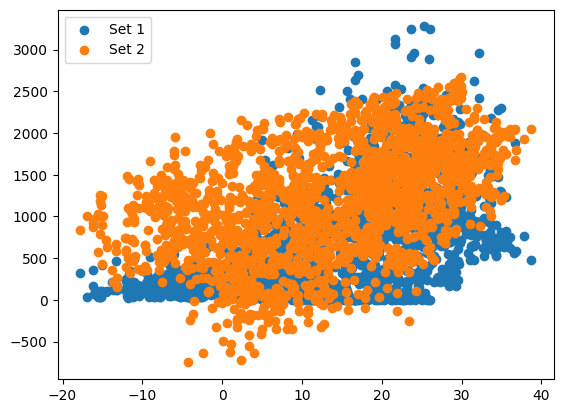

In [730]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = tools.selBest(pop, 1)[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.setWeightsLinear(best_ind)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[-0.3318859369132811, -0.7857950783552217, 1.3610939532926798, -0.7669729863772322, -0.2372940662529397, -0.36843028084215945, 1.1484860015127305, -1.576530108193588, -0.2955809914438553, -1.1303425712882231, 1.4769911069709807, 0.5499174307755361, -1.977769463827661, -0.22035096457128708, -0.2325595478007067, 0.25819136426518563, 0.8250974267106818, -2.06705795273471, -2.4352454751190384, -0.3800329951106385, 2.129528730871884, -0.7124835849586653, -0.27577159933384127, 0.11111389615104557, -0.674317989245557, -0.2294257968592351, 1.3850965899614154, 0.22590285415061181, 0.2238432153349839, -0.9547670457743576, -0.7198443197998426, -1.083072287765506, -0.015424772269650888, 0.12632359915432964, 1.1137174114203758, -0.6637643836678773, -0.30033920267431413, 0.5139338752866633, 0.5600082166986408, 1.4132614224987856, -1.4098965225903577, 0.4577939889013413, -0.44345682129866437, 0.5334924188941439, 1.0737493225624273, 0.5315732786765872, -0.3004916104806527, -1.9245144836787507, -1.3049

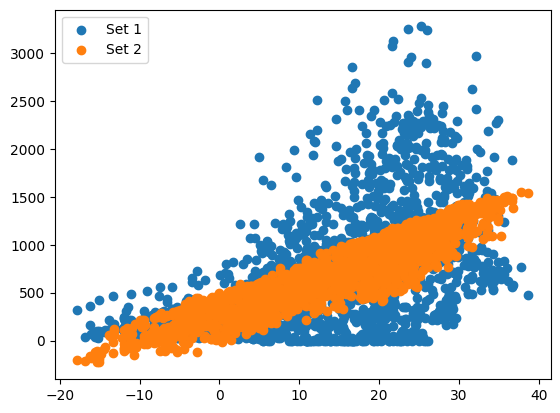

In [731]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof.items[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.setWeightsLinear(best_ind)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([942.9786629]), array([1094.98633811]), array([-77.64520472]), array([491.78063209]), array([921.50074038]), array([422.93985789]), array([-94.67918677]), array([313.3282539]), array([748.16107718]), array([240.95967074]), array([283.70790301]), array([789.41233769]), array([734.74981393]), array([1442.40376335]), array([303.94696443]), array([796.46855436]), array([684.81674797]), array([1142.78219801]), array([798.83460658]), array([91.49977196]), array([305.42121431]), array([1001.92391184]), array([557.58063456]), array([1378.9574722]), array([721.85932398]), array([1142.63544386]), array([544.56080333]), array([941.39590652]), array([427.68577405]), array([266.49478095]), array([1117.2871715]), array([815.23536827]), array([542.73948782]), array([1271.23241875]), array([572.09674542]), array([-56.50300614]), array([491.48108983]), array([982.20115848]), array([705.51316677]), array([183.9132163]), array([1256.06697112]), array([583.1513152]), array([955.08545612]), array([8

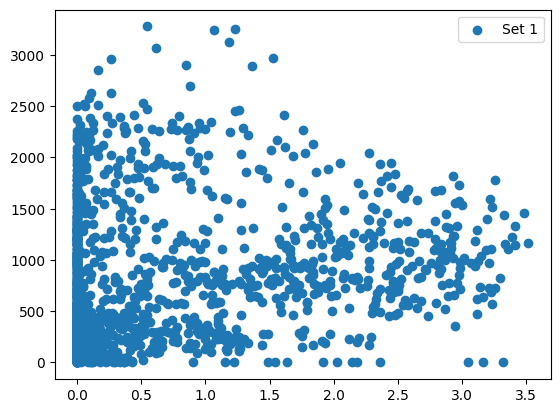

[-0.3318859369132811, -0.7857950783552217, 1.3610939532926798, -0.7669729863772322, -0.2372940662529397, -0.36843028084215945, 1.1484860015127305, -1.576530108193588, -0.2955809914438553, -1.1303425712882231, 1.4769911069709807, 0.5499174307755361, -1.977769463827661, -0.22035096457128708, -0.2325595478007067, 0.25819136426518563, 0.8250974267106818, -2.06705795273471, -2.4352454751190384, -0.3800329951106385, 2.129528730871884, -0.7124835849586653, -0.27577159933384127, 0.11111389615104557, -0.674317989245557, -0.2294257968592351, 1.3850965899614154, 0.22590285415061181, 0.2238432153349839, -0.9547670457743576, -0.7198443197998426, -1.083072287765506, -0.015424772269650888, 0.12632359915432964, 1.1137174114203758, -0.6637643836678773, -0.30033920267431413, 0.5139338752866633, 0.5600082166986408, 1.4132614224987856, -1.4098965225903577, 0.4577939889013413, -0.44345682129866437, 0.5334924188941439, 1.0737493225624273, 0.5315732786765872, -0.3004916104806527, -1.9245144836787507, -1.3049

In [732]:
# Assuming you have two sets of data:
x_values1 = test_data['Sunshine'].to_list()
y_values1 = test_data['Count'].to_list()

# x_values2 = test_data['Rain'].to_list()
# y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
# plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()
print(best_ind)

[array([942.9786629]), array([1094.98633811]), array([-77.64520472]), array([491.78063209]), array([921.50074038]), array([422.93985789]), array([-94.67918677]), array([313.3282539]), array([748.16107718]), array([240.95967074]), array([283.70790301]), array([789.41233769]), array([734.74981393]), array([1442.40376335]), array([303.94696443]), array([796.46855436]), array([684.81674797]), array([1142.78219801]), array([798.83460658]), array([91.49977196]), array([305.42121431]), array([1001.92391184]), array([557.58063456]), array([1378.9574722]), array([721.85932398]), array([1142.63544386]), array([544.56080333]), array([941.39590652]), array([427.68577405]), array([266.49478095]), array([1117.2871715]), array([815.23536827]), array([542.73948782]), array([1271.23241875]), array([572.09674542]), array([-56.50300614]), array([491.48108983]), array([982.20115848]), array([705.51316677]), array([183.9132163]), array([1256.06697112]), array([583.1513152]), array([955.08545612]), array([8

ValueError: x and y must be the same size

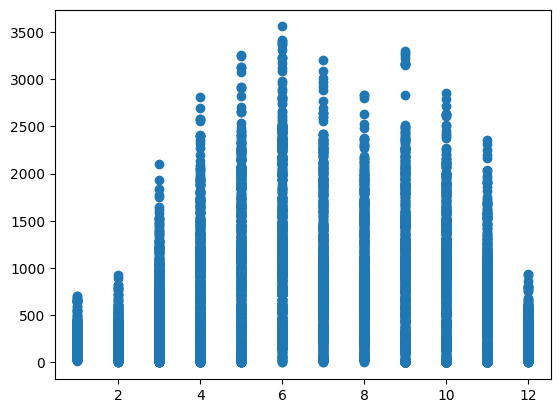

In [733]:
# Assuming you have two sets of data:
x_values1 = evdata['Month'].to_list()
y_values1 = evdata['Count'].to_list()

x_values2 = evdata['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

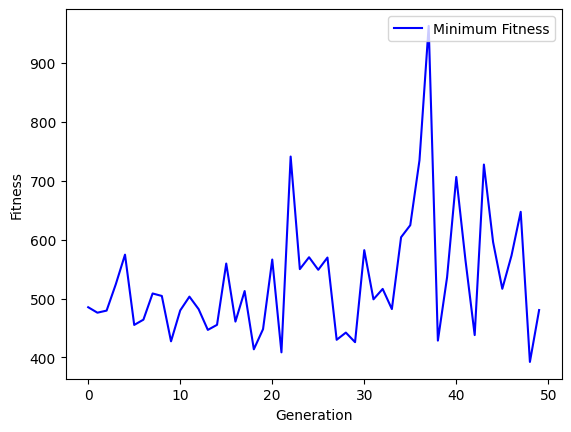

In [ ]:
## Graph fitness over generations

gen = logbook.select("gen")
fit_mins = logbook.select("min")


plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")

plt.show()